In [1]:
_ = """
Desciption
- Visuelle products
- Not use of pytorch_forecasting
- year, month, day, dayofweek as positional embedding feature
- Extract attention from MY transformer but not from image model's
"""

# Configurations

### Import

In [2]:
import os
import joblib
import random
from IPython.display import clear_output
import copy
from tqdm import tqdm

import numpy as np
import pandas as pd; pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tslearn.utils import to_time_series_dataset

import torch
from PIL import Image
from torchvision import transforms
from transformers import SwinModel, SwinConfig, ViTModel, ViTConfig, Mask2FormerModel, Mask2FormerConfig, ViTFeatureExtractor
import matplotlib.cm as cm
import cv2
import pytorch_forecasting as pf
from pytorch_forecasting.models.base_model import BaseModelWithCovariates
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
import torch.nn.functional as F

device = torch.device("cuda:0")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Params

In [3]:
# Sampling parameter
n_smaples = None

# Data parameter
random_state = 0
encoder_len = 365
pred_len = 30
batch_size = 256
# batch_size = 10
valid_start_date = "2020-01-22"

# Model hyperparameter
d_model = 128; d_model = 256; d_model = 512
nhead = 4; nhead = 8
d_ff = 256; d_ff = 512; d_ff = 1024
dropout = 0.3
num_layers = 4; num_layers = 6

# Seed set
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)

# Data

### Read

In [4]:
# Read transaction
df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
df_train_raw = df_trans[df_trans["t_dat"] < valid_start_date]
df_valid_raw = df_trans[df_trans["t_dat"] >= valid_start_date]

### Preprocess

In [7]:
def preprocess(data, is_train=True):
    data = data.copy()

    # Make sales
    data = data.groupby(["article_id", "t_dat"], as_index=False).agg(sales=("customer_id","size"), price=("price","mean"))
    
    # Expand date
    def func(x):
        date_min = x["t_dat"].min()
        date_max = x["t_dat"].max()

        date_ref = pd.DataFrame(pd.date_range(date_min, date_max, freq="d"), columns=["t_dat"])
        x = pd.merge(date_ref, x, on="t_dat", how="left")
        return x

    data = data.groupby("article_id", as_index=False).apply(lambda x: func(x)).reset_index(drop=True)
    data["sales"] = data["sales"].fillna(0)
    data["price"] = data["price"].fillna(method="ffill")
    data["article_id"] = data["article_id"].fillna(method="ffill")
    data["price"] = data["price"].fillna(method="ffill")

    # Generate temporal information
    data["year"] = data["t_dat"].dt.year
    data["month"] = data["t_dat"].dt.month
    data["week"] = data["t_dat"].dt.isocalendar().week
    data.loc[(data["month"] == 12) & (data["week"] < 10), "year"] = data["year"] + 1
    data.loc[(data["month"] == 1) & (data["week"] > 10), "year"] = data["year"] - 1
    data["dayofweek"] = data["t_dat"].dt.dayofweek
    data["day"] = data["t_dat"].dt.day

    data["month_sin"] = np.sin(2 * np.pi * data["month"]/12)
    data["month_cos"] = np.cos(2 * np.pi * data["month"]/12)

    data["week_sin"] = np.sin(2 * np.pi * data["week"]/53)
    data["week_cos"] = np.cos(2 * np.pi * data["week"]/53)

    data["dayofweek_sin"] = np.sin(2 * np.pi * data["dayofweek"]/7)
    data["dayofweek_cos"] = np.cos(2 * np.pi * data["dayofweek"]/7)

    data["day_sin"] = np.sin(2 * np.pi * data["day"]/365)
    data["day_cos"] = np.cos(2 * np.pi * data["day"]/365)
    
    # Aggregate with list
    data = data.groupby("article_id", as_index=False)[["sales", "price", "year", "month_sin", "month_cos", "week_sin", "week_cos", "day_sin", "day_cos", "dayofweek_sin", "dayofweek_cos"]].agg(list)
    data["size"] = data["sales"].str.len()

    # img_path
    data["img_path"] = data["article_id"].apply(lambda x: f'../HnM/images/{x[:3]}/{x}.jpg')
    data["is_valid"] = data["img_path"].apply(lambda x: 1 if os.path.isfile(x) else 0) # Check whether the article has corresponding image file
    data = data[data["is_valid"] == 1].drop("is_valid", axis=1) # Valid if having corresponding image

    # Filter 
    if is_train:
        data = data[data["size"] > encoder_len + pred_len]
    else: 
        data = data[data["size"] > pred_len + 1]

    return data.reset_index(drop=True)

df_train_prep = preprocess(df_train_raw)
df_valid_prep = preprocess(df_valid_raw, is_train=False)

df_train_prep.to_parquet("df_train_prep.parquet")
df_valid_prep.to_parquet("df_valid_prep.parquet")

In [9]:
df_train_prep.head(1)

,article_id,sales,price,year,month_sin,month_cos,week_sin,week_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos,size,img_path
0,0108775015,"[30.0, 48.0, 11.0, 26.0, 33.0, 76.0, 53.0, 60....","[0.008444632768361514, 0.008194209039547961, 0...","[2018, 2018, 2018, 2018, 2018, 2018, 2018, 201...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.8369701987210297e-16, -1.8369701987210297e...","[-0.9785564922995039, -0.9785564922995039, -0....","[-0.2059786187410985, -0.2059786187410985, -0....","[0.3375228995941133, 0.3536761221763716, 0.369...","[0.9413173175128471, 0.9353679493131483, 0.929...","[0.43388373911755823, -0.433883739117558, -0.9...","[-0.900968867902419, -0.9009688679024191, -0.2...",484,../HnM/images/010/0108775015.jpg


### Dataset

In [4]:
df_train_prep = pd.read_parquet("df_train_prep.parquet")
df_valid_prep = pd.read_parquet("df_valid_prep.parquet")

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.sales_tensor = self.get_windowed_tensor(data["sales"].values)
        self.year_tensor = self.get_windowed_tensor(data["year"].values)

        self.monthsin_tensor = self.get_windowed_tensor(data["month_sin"].values)
        self.monthcos_tensor = self.get_windowed_tensor(data["month_cos"].values)

        self.weeksin_tensor = self.get_windowed_tensor(data["week_sin"].values)
        self.weekcos_tensor = self.get_windowed_tensor(data["week_cos"].values)

        self.daysin_tensor = self.get_windowed_tensor(data["day_sin"].values)
        self.daycos_tensor = self.get_windowed_tensor(data["day_cos"].values)

        self.dayofweeksin_tensor = self.get_windowed_tensor(data["dayofweek_sin"].values)
        self.dayofweekcos_tensor = self.get_windowed_tensor(data["dayofweek_cos"].values)

        self.img = self.get_windowed_img_tensor(data[["sales", "img_path"]].values)

    def get_windowed_img_tensor(self, data):
        img_tensor_li = []
        
        for d in data:
            d, img = d

            d = d.astype(float)
            d = torch.FloatTensor(d).unfold(0, encoder_len+pred_len, 1)

            img = np.repeat(np.array([img]), d.shape[0], 0)
            img_tensor_li.append(img)
            
        img_tensor = np.concatenate(img_tensor_li)
        return img_tensor
    
    def get_windowed_tensor(self, data):
        windowed_tensor_li = []
        for d in data:
            d = d.astype(float)
            d = torch.FloatTensor(d).unfold(0, encoder_len+pred_len, 1)
            windowed_tensor_li.append(d)
        windowed_tensor = torch.concat(windowed_tensor_li)
        return windowed_tensor

    def __len__(self):
        return self.sales_tensor.shape[0]
    
    def __getitem__(self, idx):
        sales = np.log1p(self.sales_tensor[idx][:-pred_len]).unsqueeze(-1)
        y = np.log1p(self.sales_tensor[idx][-pred_len:])
        
        year = self.year_tensor[idx][:-pred_len].unsqueeze(-1)
        
        month_sin = self.monthsin_tensor[idx][:-pred_len].type(torch.IntTensor).unsqueeze(-1)
        month_cos = self.monthcos_tensor[idx][:-pred_len].type(torch.IntTensor).unsqueeze(-1)

        week_sin = self.weeksin_tensor[idx][:-pred_len].type(torch.IntTensor).unsqueeze(-1)
        week_cos = self.weekcos_tensor[idx][:-pred_len].type(torch.IntTensor).unsqueeze(-1)

        day_sin = self.daysin_tensor[idx][:-pred_len].type(torch.IntTensor).unsqueeze(-1)
        day_cos = self.daycos_tensor[idx][:-pred_len].type(torch.IntTensor).unsqueeze(-1)

        dayofweek_sin = self.dayofweeksin_tensor[idx][:-pred_len].type(torch.IntTensor).unsqueeze(-1)
        dayofweek_cos = self.dayofweekcos_tensor[idx][:-pred_len].type(torch.IntTensor).unsqueeze(-1)

        img = Image.open(self.img[idx]).convert("RGB")
        img = self.transform(img).numpy()
        
        return sales, year, month_sin, month_cos, week_sin, week_cos, day_sin, day_cos, dayofweek_sin, dayofweek_cos, img, y

train_dataset = TrainDataset(df_train_prep)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, prefetch_factor=8)

for data in train_dataloader:
    sales, year, month_sin, month_cos, week_sin, week_cos, day_sin, day_cos, dayofweek_sin, dayofweek_cos, img, y = data
    print("sales:", sales.shape)
    print("year:", year.shape)
    print("month_sin:", month_sin.shape)
    print("month_cos:", month_cos.shape)
    print("week_sin:", week_sin.shape)
    print("week_cos:", week_cos.shape)
    print("day_sin:", day_sin.shape)
    print("day_cos:", day_cos.shape)
    print("dayofweek_sin:", dayofweek_sin.shape)
    print("dayofweek_cos:", dayofweek_cos.shape)
    print("img:", img.shape)
    print("_"*100)
    print("y:", y.shape)
    break

sales: torch.Size([256, 365, 1])
year: torch.Size([256, 365, 1])
month_sin: torch.Size([256, 365, 1])
month_cos: torch.Size([256, 365, 1])
week_sin: torch.Size([256, 365, 1])
week_cos: torch.Size([256, 365, 1])
day_sin: torch.Size([256, 365, 1])
day_cos: torch.Size([256, 365, 1])
dayofweek_sin: torch.Size([256, 365, 1])
dayofweek_cos: torch.Size([256, 365, 1])
img: torch.Size([256, 3, 224, 224])
____________________________________________________________________________________________________
y: torch.Size([256, 30])


# Architecture

In [5]:
class VitEncoderLayer(torch.nn.TransformerEncoderLayer):
    def __init__(self, d_model, nhead, emb_size=768, expansion=4):
        super().__init__(d_model, nhead)
    
        # Multihead Attention
        self.layer_norm1 = torch.nn.LayerNorm(emb_size)
        self.mha = torch.nn.MultiheadAttention(embed_dim=emb_size, num_heads=nhead, dropout=dropout, batch_first=True)
        self.dropout1 = torch.nn.Dropout(dropout)

        # Feed forward
        self.layer_norm2 = torch.nn.LayerNorm(emb_size)
        self.linear1 = torch.nn.Linear(emb_size, emb_size*expansion)
        self.gelu = torch.nn.GELU()
        self.dropout2 = torch.nn.Dropout(dropout)
        self.linear2 = torch.nn.Linear(emb_size*expansion, emb_size)
        self.dropout3 = torch.nn.Dropout(dropout)
    
    def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=False):
    #######################################################################################################################################################################################################################
        src_key_padding_mask = F._canonical_mask(
            mask=src_key_padding_mask,
            mask_name="src_key_padding_mask",
            other_type=F._none_or_dtype(src_mask),
            other_name="src_mask",
            target_type=src.dtype)

        src_mask = F._canonical_mask(
            mask=src_mask,
            mask_name="src_mask",
            other_type=None,
            other_name="",
            target_type=src.dtype,
            check_other=False        )

        # see Fig. 1 of https://arxiv.org/pdf/2002.04745v1.pdf
        why_not_sparsity_fast_path = ''
        if not src.dim() == 3:
            why_not_sparsity_fast_path = f"input not batched; expected src.dim() of 3 but got {src.dim()}"
        elif self.training:
            why_not_sparsity_fast_path = "training is enabled"
        elif not self.self_attn.batch_first :
            why_not_sparsity_fast_path = "self_attn.batch_first was not True"
        elif not self.self_attn._qkv_same_embed_dim :
            why_not_sparsity_fast_path = "self_attn._qkv_same_embed_dim was not True"
        elif not self.activation_relu_or_gelu:
            why_not_sparsity_fast_path = "activation_relu_or_gelu was not True"
        elif not (self.norm1.eps == self.norm2.eps):
            why_not_sparsity_fast_path = "norm1.eps is not equal to norm2.eps"
        elif src.is_nested and (src_key_padding_mask is not None or src_mask is not None):
            why_not_sparsity_fast_path = "neither src_key_padding_mask nor src_mask are not supported with NestedTensor input"
        elif self.self_attn.num_heads % 2 == 1:
            why_not_sparsity_fast_path = "num_head is odd"
        elif torch.is_autocast_enabled():
            why_not_sparsity_fast_path = "autocast is enabled"
        if not why_not_sparsity_fast_path:
            tensor_args = (
                src,
                self.self_attn.in_proj_weight,
                self.self_attn.in_proj_bias,
                self.self_attn.out_proj.weight,
                self.self_attn.out_proj.bias,
                self.norm1.weight,
                self.norm1.bias,
                self.norm2.weight,
                self.norm2.bias,
                self.linear1.weight,
                self.linear1.bias,
                self.linear2.weight,
                self.linear2.bias,
            )

            # We have to use list comprehensions below because TorchScript does not support
            # generator expressions.
            _supported_device_type = ["cpu", "cuda", torch.utils.backend_registration._privateuse1_backend_name]
            if torch.overrides.has_torch_function(tensor_args):
                why_not_sparsity_fast_path = "some Tensor argument has_torch_function"
            elif not all((x.device.type in _supported_device_type) for x in tensor_args):
                why_not_sparsity_fast_path = ("some Tensor argument's device is neither one of "
                                              f"{_supported_device_type}")
            elif torch.is_grad_enabled() and any(x.requires_grad for x in tensor_args):
                why_not_sparsity_fast_path = ("grad is enabled and at least one of query or the "
                                              "input/output projection weights or biases requires_grad")

            if not why_not_sparsity_fast_path:
                merged_mask, mask_type = self.self_attn.merge_masks(src_mask, src_key_padding_mask, src)
                return torch._transformer_encoder_layer_fwd(
                    src,
                    self.self_attn.embed_dim,
                    self.self_attn.num_heads,
                    self.self_attn.in_proj_weight,
                    self.self_attn.in_proj_bias,
                    self.self_attn.out_proj.weight,
                    self.self_attn.out_proj.bias,
                    self.activation_relu_or_gelu == 2,
                    self.norm_first,
                    self.norm1.eps,
                    self.norm1.weight,
                    self.norm1.bias,
                    self.norm2.weight,
                    self.norm2.bias,
                    self.linear1.weight,
                    self.linear1.bias,
                    self.linear2.weight,
                    self.linear2.bias,
                    merged_mask,
                    mask_type,
                )
    ########################################################################################################################################################################################################################
        # Multihead Attention
        layer_norm1 = self.layer_norm1(src)
        self_attn = self.mha(
                    query = layer_norm1,
                    key = layer_norm1,
                    value = layer_norm1,
                    need_weights = False
                    )[0]
        dropout1 = self.dropout1(self_attn)

        # Residual1
        residual1 = src + dropout1

        # Feed forward
        layer_norm2 = self.layer_norm2(residual1)
        linear1 = self.linear1(layer_norm2)
        gelu = self.gelu(linear1)
        dropout2 = self.dropout2(gelu)
        linear2 = self.linear2(dropout2)
        dropout3 = self.dropout3(linear2)

        # Residual2
        residual2 = residual1 + dropout3

        return residual2
   
class PositionalEmbedder(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        # Raw embedder
        self.year_embedder = torch.nn.Linear(1, d_model)
        self.month_embedder = torch.nn.Embedding(num_embeddings=12, embedding_dim=d_model)
        self.week_embedder = torch.nn.Embedding(num_embeddings=52, embedding_dim=d_model)
        self.day_embedder = torch.nn.Embedding(num_embeddings=365, embedding_dim=d_model)
        self.dayofweek_embedder = torch.nn.Embedding(num_embeddings=7, embedding_dim=d_model)
        
        # Concatenate
        self.layer_norm1 = torch.nn.LayerNorm(d_model*5)
        self.linear1 = torch.nn.Linear(d_model*5, d_model)

        # Feed forward concatenated positions
        self.linear2 = torch.nn.Linear(d_model, d_model)
        self.activation1 = torch.nn.ELU()
        self.linear3 = torch.nn.Linear(d_model, d_model)
        self.dropout = torch.nn.Dropout(dropout)

        # Residual
        self.layer_norm2 = torch.nn.LayerNorm(d_model)
    
    def forward(self, year, month, week, dayofweek, day):
        year_embedding = self.year_embedder(year)
        month_embedding = self.month_embedder(month)
        week_embedding = self.week_embedder(week)
        day_embedding = self.day_embedder(day)
        dayofweek_embedding = self.day_embedder(dayofweek)

        concat = self.linear1(self.layer_norm1(torch.concat([year_embedding, month_embedding, week_embedding, day_embedding, dayofweek_embedding], dim=-1)))
        feed_forward = self.dropout(self.linear3(self.activation1(self.linear2(concat))))
        residual = self.layer_norm2(concat + feed_forward)
        return residual

class SeqDecoderLayer(torch.nn.TransformerDecoderLayer):
    def __init__(self, d_model, nhead, batch_first=True):
        super().__init__(d_model, nhead, batch_first=batch_first)

class Transformer(torch.nn.Module):
    def __init__(self, d_model, nhead, dropout, d_ff, num_layers, patch_size=16, in_channels=3, emb_size=768, img_size=224):
        super().__init__()
        
      # Make patches
        self.patch_size = patch_size
        self.projection = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, emb_size, patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e')
        )
        self.positions = torch.nn.Parameter(torch.randn((img_size // patch_size) ** 2, emb_size))

      # Encoder
        # self.encoder_layer = VitEncoderLayer(d_model, nhead)
        # self.encoder = torch.nn.TransformerEncoder(self.encoder_layer, num_layers)
        # self.linear1 = torch.nn.Linear(768, d_model)

        self.img_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.linear1 = torch.nn.Linear(768, d_model)
    
      # Decoder
        # self.seq_positional_embedder = PositionalEmbedder(d_model)
        # self.sales_embedder = torch.nn.Linear(1, d_model)
        self.conv1 = torch.nn.Conv1d(in_channels=10, out_channels=d_model, kernel_size=10, stride=2)
        self.elu1 = torch.nn.GELU()
        self.conv2 = torch.nn.Conv1d(in_channels=d_model, out_channels=d_model, kernel_size=10, padding="same")
        self.elu2 = torch.nn.GELU()
        self.conv3 = torch.nn.Conv1d(in_channels=d_model, out_channels=d_model, kernel_size=10, padding="same")
        self.elu3 = torch.nn.GELU()

        self.conv4 = torch.nn.Conv1d(in_channels=d_model, out_channels=d_model*2, kernel_size=10, stride=2)
        self.elu4 = torch.nn.GELU()
        self.conv5 = torch.nn.Conv1d(in_channels=d_model*2, out_channels=d_model*2, kernel_size=10, padding="same")
        self.elu5 = torch.nn.GELU()
        self.conv6 = torch.nn.Conv1d(in_channels=d_model*2, out_channels=d_model*2, kernel_size=10, padding="same")
        self.elu6 = torch.nn.GELU()

        self.conv7 = torch.nn.Conv1d(in_channels=d_model*2, out_channels=d_model*4, kernel_size=10, stride=2)
        self.elu7 = torch.nn.GELU()
        self.conv8 = torch.nn.Conv1d(in_channels=d_model*4, out_channels=d_model*4, kernel_size=10, padding="same")
        self.elu8 = torch.nn.GELU()
        self.conv9 = torch.nn.Conv1d(in_channels=d_model*4, out_channels=d_model*4, kernel_size=10, padding="same")
        self.elu9 = torch.nn.GELU()

        self.linear2 = torch.nn.Linear(d_model*4, d_model)
        self.elu10 = torch.nn.GELU()

        self.decoder_layer = SeqDecoderLayer(d_model, nhead)
    
      # Reshape
        self.linear3 = torch.nn.Linear(d_model, d_model)
        self.activation = torch.nn.GELU()
        self.linear4 = torch.nn.Linear(d_model, pred_len)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, sales, year, month_sin, month_cos, week_sin, week_cos, day_sin, day_cos, dayofweek_sin, dayofweek_cos, img):
      # Make patches
        # b = img.shape[0]
        # img = self.projection(img)
        # img += self.positions

      # Encoding
        # encoder_output = self.encoder(img)
        encoder_output, pooler_output = self.img_model(img).values()
        encoder_output = self.linear1(encoder_output)
    
      # Decoding
        dec_input = torch.concat([sales, year, month_sin, month_cos, week_sin, week_cos, day_sin, day_cos, dayofweek_sin, dayofweek_cos], dim=-1)
        dec_input = dec_input.permute(0,2,1)

        conv_block1 = self.elu1(self.conv1(dec_input))
        # conv_block1 = self.elu2(self.conv2(conv_block1))
        # conv_block1_fin = self.elu3(self.conv3(conv_block1))
        # conv_block1_fin += conv_block1

        conv_block2 = self.elu4(self.conv4(conv_block1))
        # conv_block2 = self.elu5(self.conv5(conv_block2))
        # conv_block2_fin = self.elu6(self.conv6(conv_block2))
        # conv_block2_fin += conv_block2

        conv_block3 = self.elu7(self.conv7(conv_block2))
        # conv_block3 = self.elu8(self.conv8(conv_block3))
        # conv_block3_fin = self.elu9(self.conv9(conv_block3))
        # conv_block3_fin += conv_block3

        dec_input = conv_block3.permute(0,2,1)
        dec_input = self.elu10(self.linear2(dec_input))

        decoder_output = self.decoder_layer(tgt=dec_input, memory=encoder_output)
      
      # Reshape
        output = decoder_output[:, -1]
        output = self.linear4(self.activation(self.linear3(output)))
        sigmoid_output = self.sigmoid(output)

        return sigmoid_output, output

model = Transformer(d_model, nhead, dropout, d_ff, num_layers)
model = torch.nn.DataParallel(model)
model.to(device)
""

''

# Train

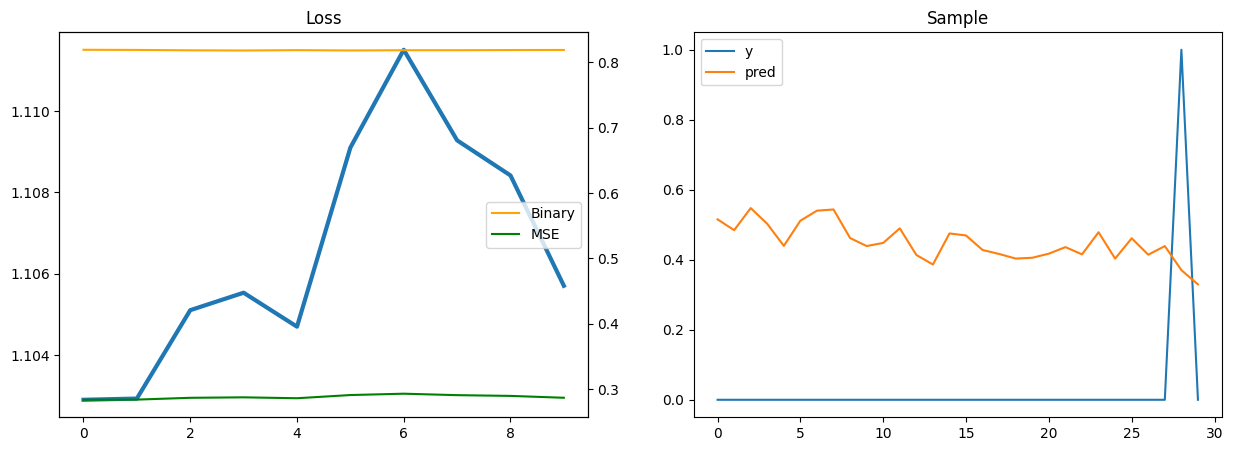

1.10543 → binary: 0.81877, mse: 0.28666: 100%|██████████| 2313/2313 [1:11:05<00:00,  1.84s/it]


In [6]:
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-7)
binary_loss_fn_ = torch.nn.BCELoss()
mse_loss_fn_ = torch.nn.MSELoss()
temp = None

def binary_loss_fn(pred, y):
    y = torch.where(y==0, 0, 1).type(torch.FloatTensor).to(device)
    loss = binary_loss_fn_(pred, y)
    return loss

def mse_loss_fn(pred, y):
    mask = torch.where(y==0, 0, 1).type(torch.FloatTensor).to(device)
    pred = pred * mask
    y = y.to(device) * mask
    loss = mse_loss_fn_(pred, y)
    return loss

def plot_sample(y, pred, total_loss_li, binary_loss_li, mse_loss_li):
    # Plot sample
    clear_output(wait=True)
    y_sample = y[-1]
    pred_sample = pred[-1].detach().cpu()
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(total_loss_li, label="Total", linewidth=3)
    plt.twinx()
    plt.plot(binary_loss_li, label="Binary", color="orange")
    plt.plot(mse_loss_li, label="MSE", color="green")
    
    plt.title("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.expm1(y_sample), label="y")
    plt.plot(np.expm1(pred_sample), label="pred")
    plt.title("Sample")
    plt.legend()
    plt.show()

def train():
    model.train()
    total_loss_li, binary_loss_li, mse_loss_li = [], [], []
    mean_total_loss_li, mean_binary_loss_li, mean_mse_loss_li = [], [], []
    pbar = tqdm(train_dataloader)

    for n, data in enumerate(pbar):
        sales, year, month_sin, month_cos, week_sin, week_cos, day_sin, day_cos, dayofweek_sin, dayofweek_cos, img, y = data
        
        # Train
        optimizer.zero_grad()
        sigmoid_pred, pred = model(sales.to(device), 
                    year.to(device), 
                    month_sin.to(device), 
                    month_cos.to(device), 
                    week_sin.to(device), 
                    week_cos.to(device), 
                    day_sin.to(device), 
                    day_cos.to(device), 
                    dayofweek_sin.to(device), 
                    dayofweek_cos.to(device), 
                    img.to(device), 
                    )
        sigmoid_pred = sigmoid_pred
        pred = pred

        binary_loss = binary_loss_fn(sigmoid_pred, y)
        mse_loss = mse_loss_fn(pred, y)
        loss = (binary_loss) + (mse_loss)
        loss.backward()
        optimizer.step()

        # Report
        total_loss_li.append(loss.item())
        binary_loss_li.append(binary_loss.item())
        mse_loss_li.append(mse_loss.item())
        pbar.set_description(f"{np.round(sum(total_loss_li[-100:])/100, 5)} → binary: {np.round(sum(binary_loss_li[-100:])/100, 5)}, mse: {np.round(sum(mse_loss_li[-100:])/100, 5)}")
        if n % 10 == 0:
            mean_total_loss_li.append(sum(total_loss_li[-100:])/100)
            mean_binary_loss_li.append(sum(binary_loss_li[-100:])/100)
            mean_mse_loss_li.append(sum(mse_loss_li[-100:])/100)
            
            calc_pred = torch.where(sigmoid_pred>0.5, 1, 0) * pred
            plot_sample(y, calc_pred, mean_total_loss_li[-10:], mean_binary_loss_li[-10:], mean_mse_loss_li[-10:])

epoch = 5
for e in range(epoch):
    train()
    break

In [7]:
arr = [100, 200, 0.001, 300, 11]
np.log1p(arr)

array([4.61512052e+00, 5.30330491e+00, 9.99500333e-04, 5.70711026e+00,
       2.48490665e+00])

In [8]:
# torch.save(model.state_dict(), f"model_v5.1.pth")

# Eval

In [9]:
model.eval()

for data in train_dataloader:
    sales, year, month, week, day, dayofweek, y, year_y, month_y, week_y, day_y, dayofweek_y = data
    
    # Train
    with torch.no_grad():
        sigmoid_pred, pred, atten_weight_li = model(sales.to(device), 
                                    year.to(device), 
                                    month.to(device), 
                                    week.to(device), 
                                    day.to(device), 
                                    dayofweek.to(device), 
                                    year_y.to(device), 
                                    month_y.to(device), 
                                    week_y.to(device), 
                                    day_y.to(device), 
                                    dayofweek_y.to(device))
        sigmoid_pred = sigmoid_pred.squeeze(-1)
        pred = pred.squeeze(-1)
        atten_weight = atten_weight_li[0]
        print(atten_weight.shape)
        print(atten_weight[120].sum(-1))
        print(atten_weight[120].sum(-1).shape)
    break

ValueError: Caught ValueError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_2406307/2823742851.py", line 237, in forward
    encoder_output, pooler_output = self.img_model(img).values()
  File "/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/transformers/models/vit/modeling_vit.py", line 583, in forward
    embedding_output = self.embeddings(
  File "/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/transformers/models/vit/modeling_vit.py", line 121, in forward
    batch_size, num_channels, height, width = pixel_values.shape
ValueError: not enough values to unpack (expected 4, got 2)


<Axes: >

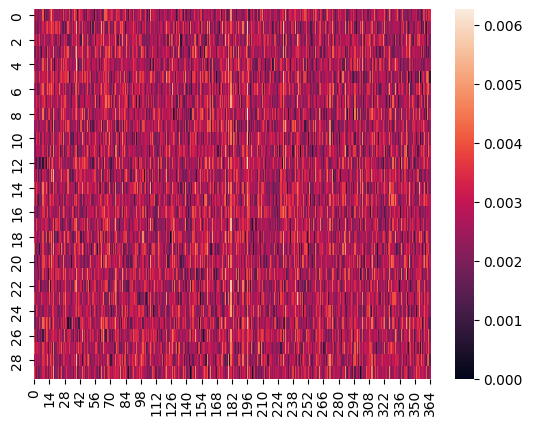

In [ ]:
import seaborn as sns

arr = atten_weight[10].cpu().numpy()
sns.heatmap(arr)